In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set()
from imblearn.over_sampling import SMOTE 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


In [2]:
pd.set_option("display.max_columns", None)

## 1. Explore

#### recall in the eda notebook, we did some preliminary eda to see which independent vars had the greatest impact on attrition

In [9]:
data = pd.read_csv("general_data.csv",sep=",")

In [11]:
data['PercentSalaryHike'].unique()

array([11, 15, 12, 13, 22, 21, 17, 14, 16, 18, 23, 19, 20, 24, 25, 10,  5,
        9,  3,  7,  2,  4,  8,  6,  1])

In [10]:
data.head()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,51,Travel_Rarely,Sales,5,2,Life_Sciences,1,1,Female,1,Healthcare_Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,1,3,3.0,4.0,3.0
1,No,32,Travel_Frequently,Research_Development,14,4,Other,1,3,Male,4,Sales_Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,3,2,3.0,2.0,2.0
2,No,38,Non-Travel,Research_Development,2,5,Life_Sciences,1,4,Male,3,Human_Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,3,4,2.0,2.0,4.0
3,No,32,Travel_Rarely,Research_Development,8,1,Medical,1,5,Male,1,Sales_Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,1,3,4.0,4.0,3.0
4,No,46,Travel_Rarely,Research_Development,6,3,Life_Sciences,1,6,Female,4,Research_Director,Married,40710,3.0,Y,13,8,0,28.0,5,7,7,7,3,3,4.0,3.0,2.0


In [5]:
data.isnull().sum()

Attrition                   0
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
PerformanceRating           0
JobInvolvement              0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            22
dtype: int64

In [6]:
data['NumCompaniesWorked_Missing'] = np.where(data['NumCompaniesWorked'] >= 0, 1, 0)
data['TotalWorkingYears_Missing'] = np.where(data['TotalWorkingYears'] >= 0, 1, 0)
data['EnvironmentSatisfaction_Missing'] = np.where(data['EnvironmentSatisfaction'] >= 0, 1, 0)
data['JobSatisfaction_Missing'] = np.where(data['JobSatisfaction'] >= 0, 1, 0)
data['WorkLifeBalance_Missing'] = np.where(data['WorkLifeBalance'] >= 0, 1, 0)

In [7]:
data = data.fillna(data.mean())

In [8]:
#Drop unecessary columns
data.drop(['EmployeeCount','EmployeeID','StandardHours','Over18'],\
          axis=1,inplace=True)

In [9]:
#Attriton is dependent var
from sklearn.preprocessing import LabelEncoder
label_encoder_y=LabelEncoder()
data['Attrition']=label_encoder_y.fit_transform(data['Attrition'])

In [10]:
data.head()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked_Missing,TotalWorkingYears_Missing,EnvironmentSatisfaction_Missing,JobSatisfaction_Missing,WorkLifeBalance_Missing
0,0,51,Travel_Rarely,Sales,5,2,Life_Sciences,Female,1,Healthcare_Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,1,3,3.0,4.0,3.0,1,1,1,1,1
1,0,32,Travel_Frequently,Research_Development,14,4,Other,Male,4,Sales_Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,3,2,3.0,2.0,2.0,1,1,1,1,1
2,0,38,Non-Travel,Research_Development,2,5,Life_Sciences,Male,3,Human_Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,3,4,2.0,2.0,4.0,1,1,1,1,1
3,0,32,Travel_Rarely,Research_Development,8,1,Medical,Male,1,Sales_Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,1,3,4.0,4.0,3.0,1,1,1,1,1
4,0,46,Travel_Rarely,Research_Development,6,3,Life_Sciences,Female,4,Research_Director,Married,40710,3.0,13,0,28.0,5,7,7,7,3,3,4.0,3.0,2.0,1,1,1,1,1


In [11]:
#Make a list of variables for correlation

corr_cols = data[['Age','Attrition','BusinessTravel','DistanceFromHome','Education', 'EducationField','Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance' ]]

#### we see a strong negative correlation between PercentSalaryHike, WorkLifeBalance, and JobSatisfaction indicating that if these predictors are low, chances of attrition (Attrition = 1) is higher

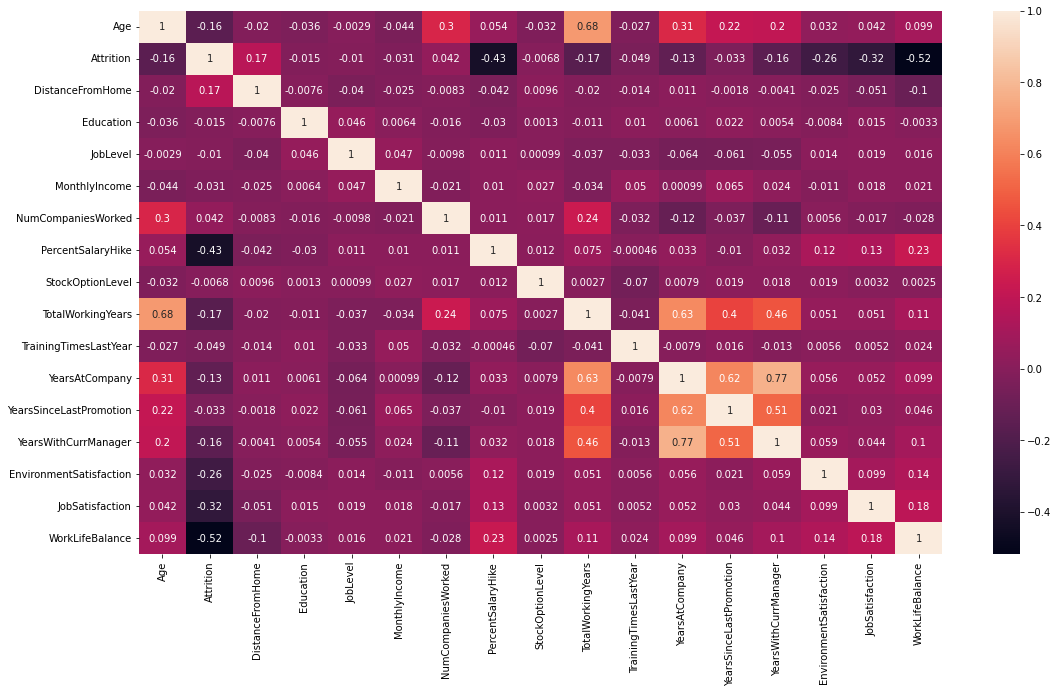

In [12]:
corr = corr_cols.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr, annot = True)
plt.show()

<AxesSubplot:xlabel='Attrition', ylabel='count'>

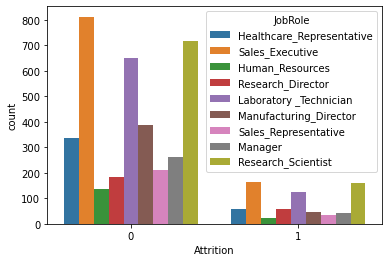

In [13]:
sns.countplot(data=data, x='Attrition', hue='JobRole')

<AxesSubplot:xlabel='Attrition', ylabel='count'>

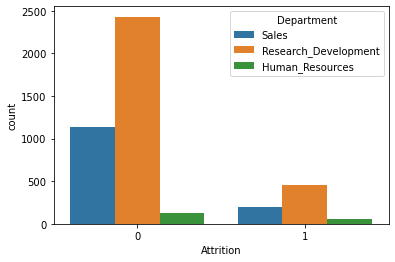

In [14]:
sns.countplot(data=data, x='Attrition', hue='Department')

<AxesSubplot:xlabel='Attrition', ylabel='count'>

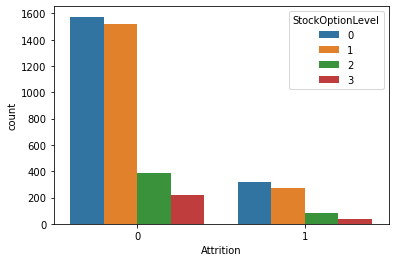

In [15]:
sns.countplot(data=data, x='Attrition', hue='StockOptionLevel')

<AxesSubplot:xlabel='Attrition', ylabel='count'>

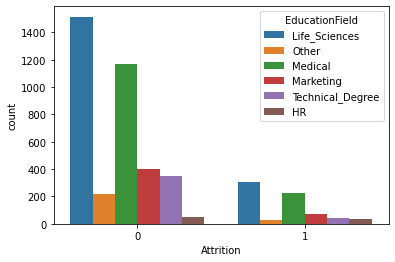

In [16]:
sns.countplot(data=data, x='Attrition', hue='EducationField')

#### for the pre-sampled data, looks like we have higher levels of attrition for employees at JobLevel == 1 & JobLevel == 2 potentially indicating newer/inexperienced employees attrite more

<AxesSubplot:xlabel='Attrition', ylabel='count'>

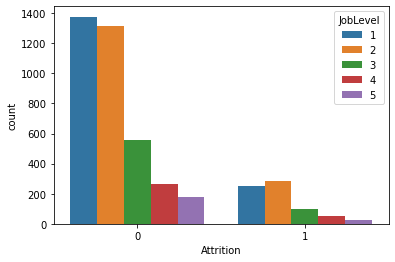

In [17]:
sns.countplot(data=data, x='Attrition', hue='JobLevel')

<AxesSubplot:xlabel='Attrition', ylabel='count'>

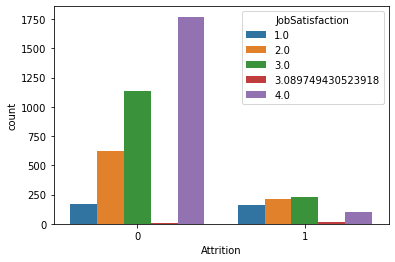

In [18]:
# not a clear indication, but something...
sns.countplot(data=data, x='Attrition', hue='JobSatisfaction')

<AxesSubplot:xlabel='Attrition', ylabel='count'>

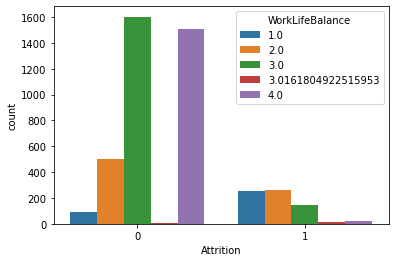

In [19]:
"""
lower work life balance score seems to indicate higher attrition
among Attrition = 1
"""  
sns.countplot(data=data, x='Attrition', hue='WorkLifeBalance')

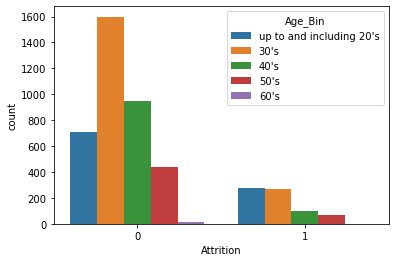

In [20]:
"""
Age seems to be a factor, early age employees (20's, 30's)
seem to attrite at a higher rate
"""
bins = [0, 29, 39, 49, 59, 70]
labels = ["up to and including 20's", "30's", "40's", "50's", "60's"]
data['Age_Bin'] = pd.cut(x=data['Age'], bins=bins, labels=labels)
sns.countplot(x = "Attrition",data=data,hue="Age_Bin")
plt.show()

In [21]:
data = data.drop(['Age_Bin'], axis=1)

#### use get_dummies to convert categorical vars into dummy/indicator vars, e.g. Gender == Gender_Male w/value of 0 or 1...0 is not male, 1 is male

In [22]:
df = \
pd.get_dummies(data, \
               columns=['Gender', 'JobRole', \
                        'BusinessTravel','Education',\
                        'EducationField','JobLevel',\
                        'MaritalStatus','Department','StockOptionLevel'],\
               drop_first=True)


#### balance imbalance in data using SMOTE since Attrition == 1 only makes up 16% of dataset

In [23]:
"""
first, separate out train, test, validate to keep us honest
"""

"""
Use the function below to create a training [70%], validation [15%], 
and test set [15%].

"""

def train_validate_test_split(df, \
                              train_percent=.7, \
                              validate_percent=.15, \
                              seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [24]:
train, validate, test = train_validate_test_split(df)

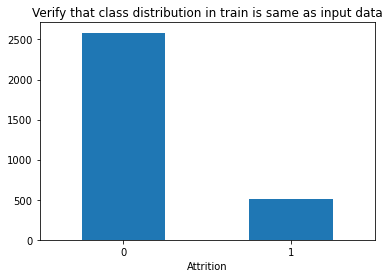

In [25]:
train.\
pivot_table(index='Attrition', aggfunc='size').\
plot(kind='bar', title='Verify that class distribution in train is same as input data').tick_params(labelrotation=0)


In [26]:
X = train.drop(['Attrition'], axis=1)
y = train['Attrition']
sm = SMOTE(random_state=42)

In [27]:
X_sm, y_sm = sm.fit_resample(X, y)

In [28]:
train.shape, validate.shape, test.shape

((3087, 52), (661, 52), (662, 52))

## 2. Modeling

In [3]:
# import mlxtend
# from mlxtend.feature_selection import SequentialFeatureSelector
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#Read in the data files
train = pd.read_csv("../Hr Analytics/data/train.csv",sep=",")
validate = pd.read_csv("../Hr Analytics/data/validate.csv",sep=",")
test = pd.read_csv("../Hr Analytics/data/test.csv",sep=",")

In [18]:
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)
validate=validate.drop(['Unnamed: 0'], axis=1)

In [19]:
train.shape, validate.shape, test.shape

((5172, 53), (661, 53), (662, 53))

In [20]:
train.head()

,Attrition,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked_Missing,TotalWorkngYears_Missing,EnvironmentSatisfaction_Missing,JobSatisfaction_Missing,WorkLifeBalance_Missing,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,0,43,6,24390,0.0,15,9.0,2,8,1,7,3,3,4.0,2.0,4.0,1,1,1,1,1,2.0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0
1,0,58,18,24500,3.0,12,32.0,2,9,1,5,3,4,4.0,4.0,4.0,1,1,1,1,1,3.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0
2,0,34,6,24390,3.0,11,14.0,2,7,5,7,3,3,4.0,4.0,3.0,1,1,1,1,1,1.0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0,49,1,73140,7.0,22,25.0,2,7,0,7,4,3,4.0,4.0,3.0,1,1,1,1,1,2.0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
4,0,55,6,50930,2.0,16,31.0,3,7,0,0,3,3,4.0,2.0,4.0,1,1,1,1,1,3.0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [8]:
cols_to_drop = []
for col in train.columns:
    if 'Missing' in col or 'Age_Bin' in col or 'JobLevel_4' in col or \
    'StockOptionLevel' in col or 'EducationField' in col:
        cols_to_drop.append(col)

In [21]:
cols_to_drop.extend(insig_vars_based_on_pvals)

In [22]:
cols_to_drop

['NumCompaniesWorked_Missing',
 'TotalWorkngYears_Missing',
 'EnvironmentSatisfaction_Missing',
 'JobSatisfaction_Missing',
 'WorkLifeBalance_Missing',
 'Age_Bin',
 'EducationField_Life_Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical_Degree',
 'JobLevel_4',
 'StockOptionLevel_1',
 'StockOptionLevel_2',
 'StockOptionLevel_3',
 'MonthlyIncome',
 'TotalWorkingYears',
 'YearsAtCompany',
 'Gender_Male',
 'JobRole_Research_Director',
 'JobRole_Sales_Representative',
 'BusinessTravel_Travel_Frequently',
 'Education_2',
 'Education_3',
 'Education_4',
 'JobLevel_2',
 'JobLevel_3',
 'JobLevel_5',
 'MaritalStatus_Married']

In [23]:
train = train.drop(cols_to_drop, axis=1)

In [24]:
formula = 'Attrition ~ '
for col in train.columns:
    if col != 'Attrition':
        if col == train.columns[-1]:
            formula += col
        else:
            formula += col + " + "

In [25]:
formula

'Attrition ~ Age + DistanceFromHome + NumCompaniesWorked + PercentSalaryHike + TrainingTimesLastYear + YearsSinceLastPromotion + YearsWithCurrManager + PerformanceRating + JobInvolvement + EnvironmentSatisfaction + JobSatisfaction + WorkLifeBalance + JobRole_Human_Resources + JobRole_Laboratory_Technician + JobRole_Manager + JobRole_Manufacturing_Director + JobRole_Research_Scientist + JobRole_Sales_Executive + BusinessTravel_Travel_Rarely + Education_5 + MaritalStatus_Single + Department_Research_Development + Department_Sales'

In [26]:
# First, we setup a baseline model using statsmodel. We can use the logit model in statsmodel and our training data set
# to create a basic model. Attrition is our y-variable. We'll include a few predictors that seem to have
# potential as predictors.
# For those familiar with the r-programming lanugage, the syntax of statsmodels should feel familiar.

log_reg = \
sm.logit(formula, data=train).\
fit()


Optimization terminated successfully.
         Current function value: 0.073188
         Iterations 10


In [14]:
pvals = log_reg.pvalues.to_dict()

In [16]:
insig_vars_based_on_pvals = []
for k, v in pvals.items():
    if v > 0.05:
        insig_vars_based_on_pvals.append(k)
# insig_vars_based_on_pvals

In [30]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 5172
Model:                          Logit   Df Residuals:                     5148
Method:                           MLE   Df Model:                           23
Date:                Tue, 23 Aug 2022   Pseudo R-squ.:                  0.8944
Time:                        21:29:59   Log-Likelihood:                -378.53
converged:                       True   LL-Null:                       -3585.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          34.9479      1.620     21.570      0.000      31.772      38.123
Age                                -0.1180      0.014     -8.660      0.000      -0.145      -0.091
DistanceFromHome                    0.0711      0.014      5.231      0.000       0.044       0.098
NumCompaniesWorked                  0.2920      0.041      7.045      0.000       0.211       0.373
PercentSalaryHike                  -0.3319      0.030    -11.055      0.000      -0.391      -0.273
TrainingTimesLastYear              -0.2819      0.087     -3.232      0.001      -0.453      -0.111
YearsSinceLastPromotion             0.1735      0.041      4.218      0.000       0.093       0.254
YearsWithCurrManager               -0.1562      0.037     -4.191      0.000      -0.229      -0.083
PerformanceRating                  -3.0638      0.193    -15.892      0.000      -3.442      -2.686
JobInvolvement                     -1.7550      0.133    -13.203      0.000      -2.016      -1.494
EnvironmentSatisfaction            -0.8804      0.100     -8.833      0.000      -1.076      -0.685
JobSatisfaction                    -1.1562      0.111    -10.379      0.000      -1.375      -0.938
WorkLifeBalance                    -2.0564      0.135    -15.203      0.000      -2.322      -1.791
JobRole_Human_Resources            -1.0932      0.613     -1.784      0.074      -2.294       0.108
JobRole_Laboratory_Technician      -0.8370      0.296     -2.831      0.005      -1.416      -0.258
JobRole_Manager                    -1.9736      0.480     -4.115      0.000      -2.914      -1.034
JobRole_Manufacturing_Director     -2.0309      0.400     -5.074      0.000      -2.815      -1.246
JobRole_Research_Scientist         -1.6580      0.314     -5.280      0.000      -2.273      -1.043
JobRole_Sales_Executive            -1.6973      0.290     -5.859      0.000      -2.265      -1.130
BusinessTravel_Travel_Rarely       -1.2623      0.210     -6.020      0.000      -1.673      -0.851
Education_5                        -1.8966      0.963     -1.970      0.049      -3.784      -0.009
MaritalStatus_Single                1.1716      0.210      5.583      0.000       0.760       1.583
Department_Research_Development    -2.6382      0.405     -6.512      0.000      -3.432      -1.844
Department_Sales                   -2.8070      0.433     -6.485      0.000      -3.655      -1.959
===================================================================================================

Possibly complete quasi-separation: A fraction 0.32 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
log_reg.tvalues = log_reg.tvalues.sort_values()

In [ ]:
log_reg.tvalues

In [27]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "Odds Ratios": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
odds_ratios['Odds Ratios'] = odds_ratios['Odds Ratios'].astype('float')
odds_ratios['Odds Ratios'] = \
odds_ratios['Odds Ratios'].apply(lambda x: '%.5f' % x)
odds_ratios['Lower CI'] = \
odds_ratios['Lower CI'].apply(lambda x: '%.5f' % x)
odds_ratios['Upper CI'] = \
odds_ratios['Upper CI'].apply(lambda x: '%.5f' % x)
# odds_ratios

In [28]:
odds_ratios = odds_ratios.sort_values(by=['Odds Ratios'], ascending=False)

In [29]:
odds_ratios

,Odds Ratios,Lower CI,Upper CI
MaritalStatus_Single,3.22715,2.13884,4.86924
Intercept,1505456502533639.25000,62888298539885.42188,36038489411244208.00000
NumCompaniesWorked,1.33916,1.23465,1.45251
YearsSinceLastPromotion,1.18946,1.09733,1.28932
DistanceFromHome,1.07364,1.04543,1.10260
Age,0.88871,0.86530,0.91276
YearsWithCurrManager,0.85538,0.79512,0.92022
TrainingTimesLastYear,0.75434,0.63578,0.89500
PercentSalaryHike,0.71756,0.67655,0.76105
JobRole_Laboratory_Technician,0.43301,0.24259,0.77292


In [30]:
len(odds_ratios)

24

#### potential savings in increasing work life balance by 0.3 -- (34590975.79, 51886463.69)




In [34]:
yearly_income = round(test['MonthlyIncome'].mean(), 2)*12
lower_salary = round(1*(round(test['MonthlyIncome'].mean(), 2) * 12), 2)
upper_salary = round(1.5*(round(test['MonthlyIncome'].mean(), 2) * 12), 2)
# lower_salary, upper_salary

In [35]:
# each unit increase in work life balance, decreases odds of attrition by 87%
prob = 1 / (1 + np.exp(-(-0.3*0.87)))
diff_in_prob = abs(0.5 - prob)
num_of_employees = len(test) * diff_in_prob
wlb_lower_bound_savings = num_of_employees * lower_salary
wlb_upper_bound_savings = num_of_employees * upper_salary
round(wlb_lower_bound_savings, 2), round(wlb_upper_bound_savings, 2)
# prob
# num_of_employees

(34590975.79, 51886463.69)

#### job satisfaction savings -- (45532241.9, 68298362.85)



In [36]:
prob = 1 / (1 + np.exp(-(-0.5*0.69)))
diff_in_prob = abs(0.5 - prob)
num_of_employees = len(test) * diff_in_prob
jb_lower_bound_savings = num_of_employees * lower_salary
jb_upper_bound_savings = num_of_employees * upper_salary
round(jb_lower_bound_savings, 2), round(jb_upper_bound_savings, 2)
# num_of_employees

(45532241.9, 68298362.85)

In [64]:
# diff in lower bound savings from jb and wlb
jb_lower_bound_savings - wlb_lower_bound_savings

10941266.110260777

#### env satisfaction savings -- (58034278.82, 87051418.23)



In [37]:
prob = 1 / (1 + np.exp(-(-0.75*0.59)))
diff_in_prob = abs(0.5 - prob)
num_of_employees = len(test) * diff_in_prob
env_sat_lower_bound_savings = num_of_employees * lower_salary
env_sat_upper_bound_savings = num_of_employees * upper_salary
round(env_sat_lower_bound_savings, 2), round(env_sat_upper_bound_savings, 2)
# num_of_employees

(58034278.82, 87051418.23)

In [66]:
max(wlb_lower_bound_savings, jb_lower_bound_savings, env_sat_lower_bound_savings)

58034278.82118434

#### training times last year savings -- (16638837.39, 24958256.08)

In [38]:
prob = 1 / (1 + np.exp(-(-0.5*0.25)))
diff_in_prob = abs(0.5 - prob)
num_of_employees = len(test) * diff_in_prob
ttly_lower_bound_savings = num_of_employees * lower_salary
ttly_upper_bound_savings = num_of_employees * upper_salary
round(ttly_lower_bound_savings, 2), round(ttly_upper_bound_savings, 2)
# num_of_employees

(16638837.39, 24958256.08)

#### increase in monthly income savings -- (4104821.94, 6157232.91)

In [39]:
# 12*(round(test['MonthlyIncome'].mean(), 2) + 7500), yearly_income
# 10.584 percent increase in yearly income
prob = 1 / (1 + np.exp(-(-.11*.28)))
diff_in_prob = abs(0.5 - prob)
num_of_employees = len(test) * diff_in_prob
monthly_lower_bound_savings = num_of_employees * lower_salary
monthly_upper_bound_savings = num_of_employees * upper_salary
round(monthly_lower_bound_savings, 2), round(monthly_upper_bound_savings, 2)
# num_of_employees

(4104821.94, 6157232.91)

In [71]:
max(wlb_lower_bound_savings, \
    jb_lower_bound_savings, env_sat_lower_bound_savings, \
    ttly_lower_bound_savings, monthly_lower_bound_savings),\
max(wlb_upper_bound_savings, \
    jb_upper_bound_savings, env_sat_upper_bound_savings, \
    ttly_upper_bound_savings, monthly_upper_bound_savings)


(58034278.82118434, 87051418.23177652)

#### analyzing ^above, here are main takeaways:
1. odds of attrition increases by 7% when distance from home increases by one unit
2. odds of attrition deceases by 31% when percent salary hike increases by one unit
3. odds of attrition decreases by 72% when job satisfaction score increases by one unit
4. odds of attrition decreases by 89% when work life balance score increases by one unit
5. odds of attrition decreases by 59% when environment satisfaction score increases by one unit
6. odds of attrition decreases by 24% when training times last year score increases by one unit

In [35]:
y_pred = log_reg.predict(test)

In [36]:
prediction = list(map(round, y_pred))

In [42]:
# prediction

#### prob that employees in test data set will attrite

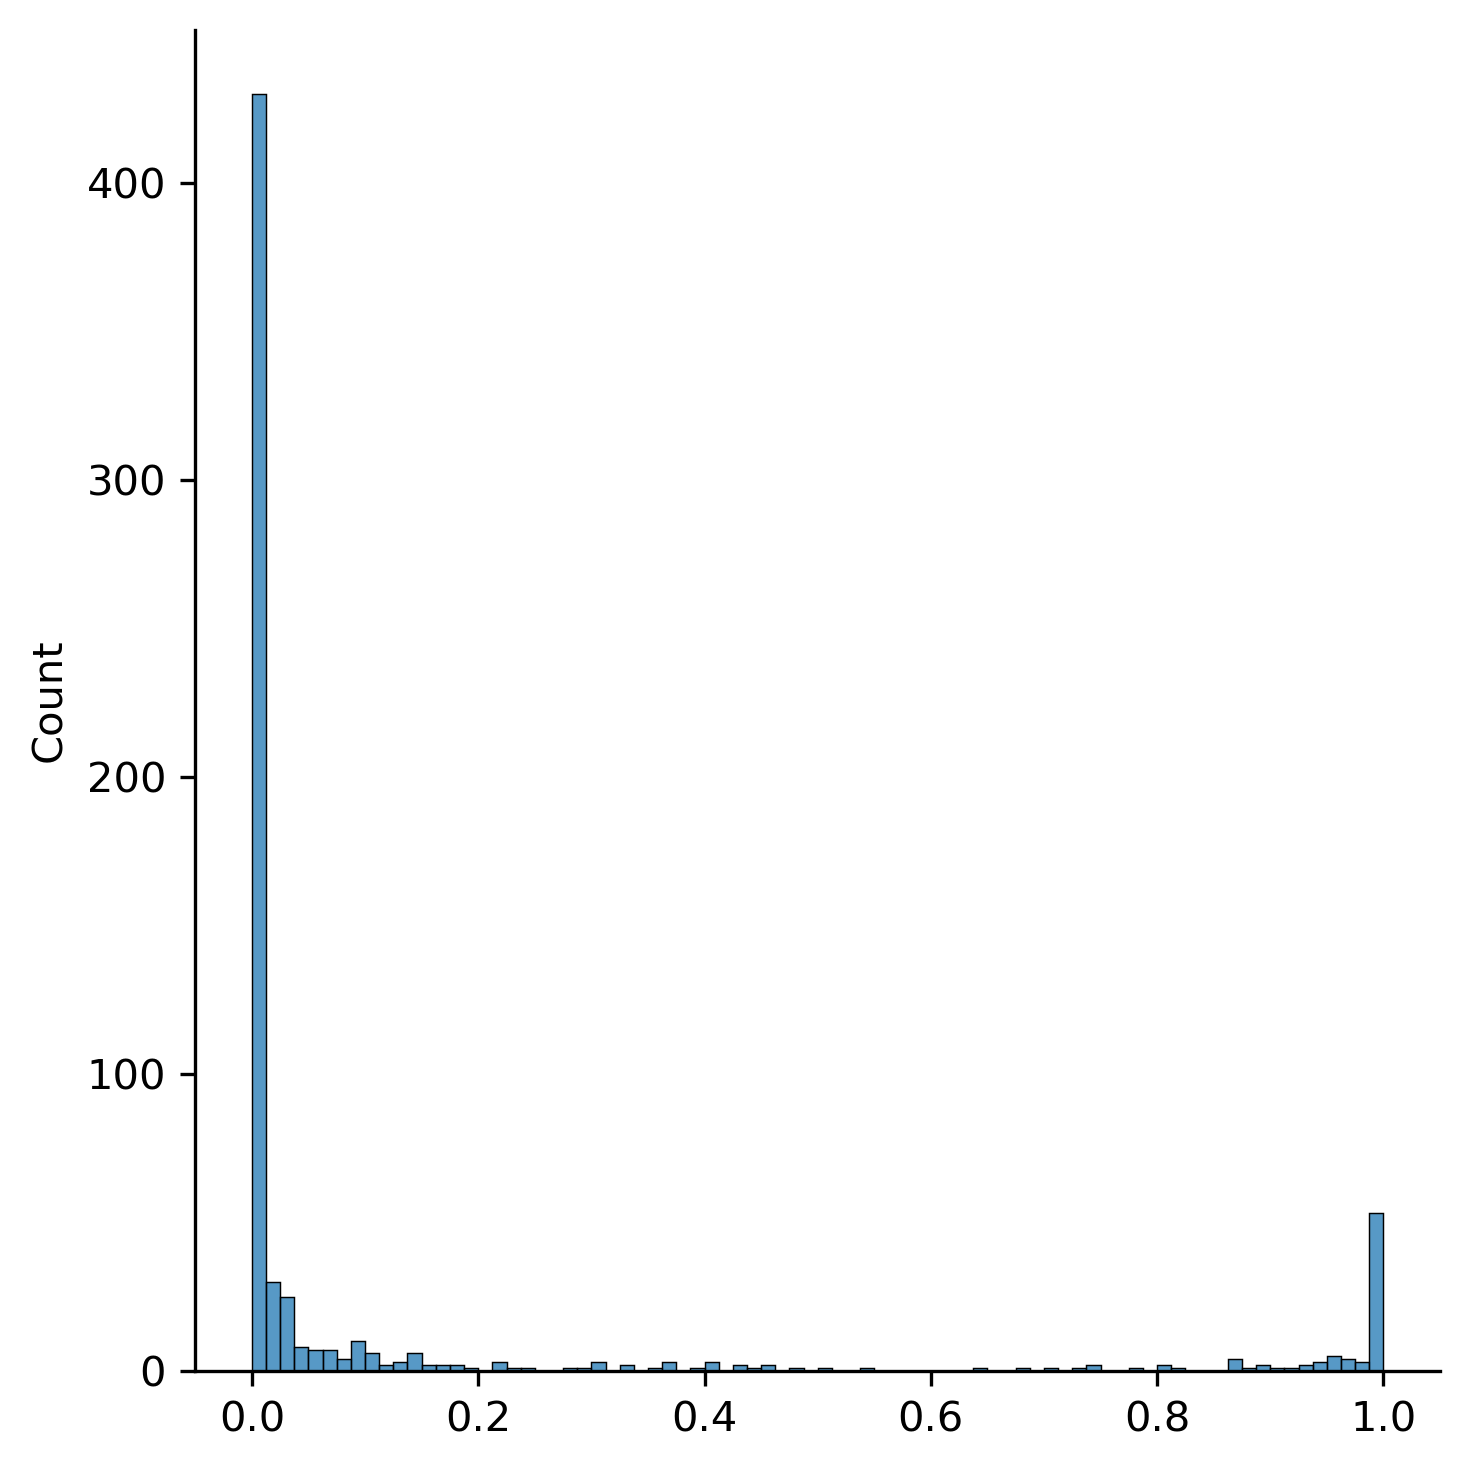

In [37]:
sns.displot(y_pred, kde=False, rug=False)

In [38]:
cm = confusion_matrix(test['Attrition'], prediction)

In [39]:
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.
# A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))

Confusion Matrix : 
 [[547  16]
 [ 24  75]]
Test accuracy =  0.9395770392749244


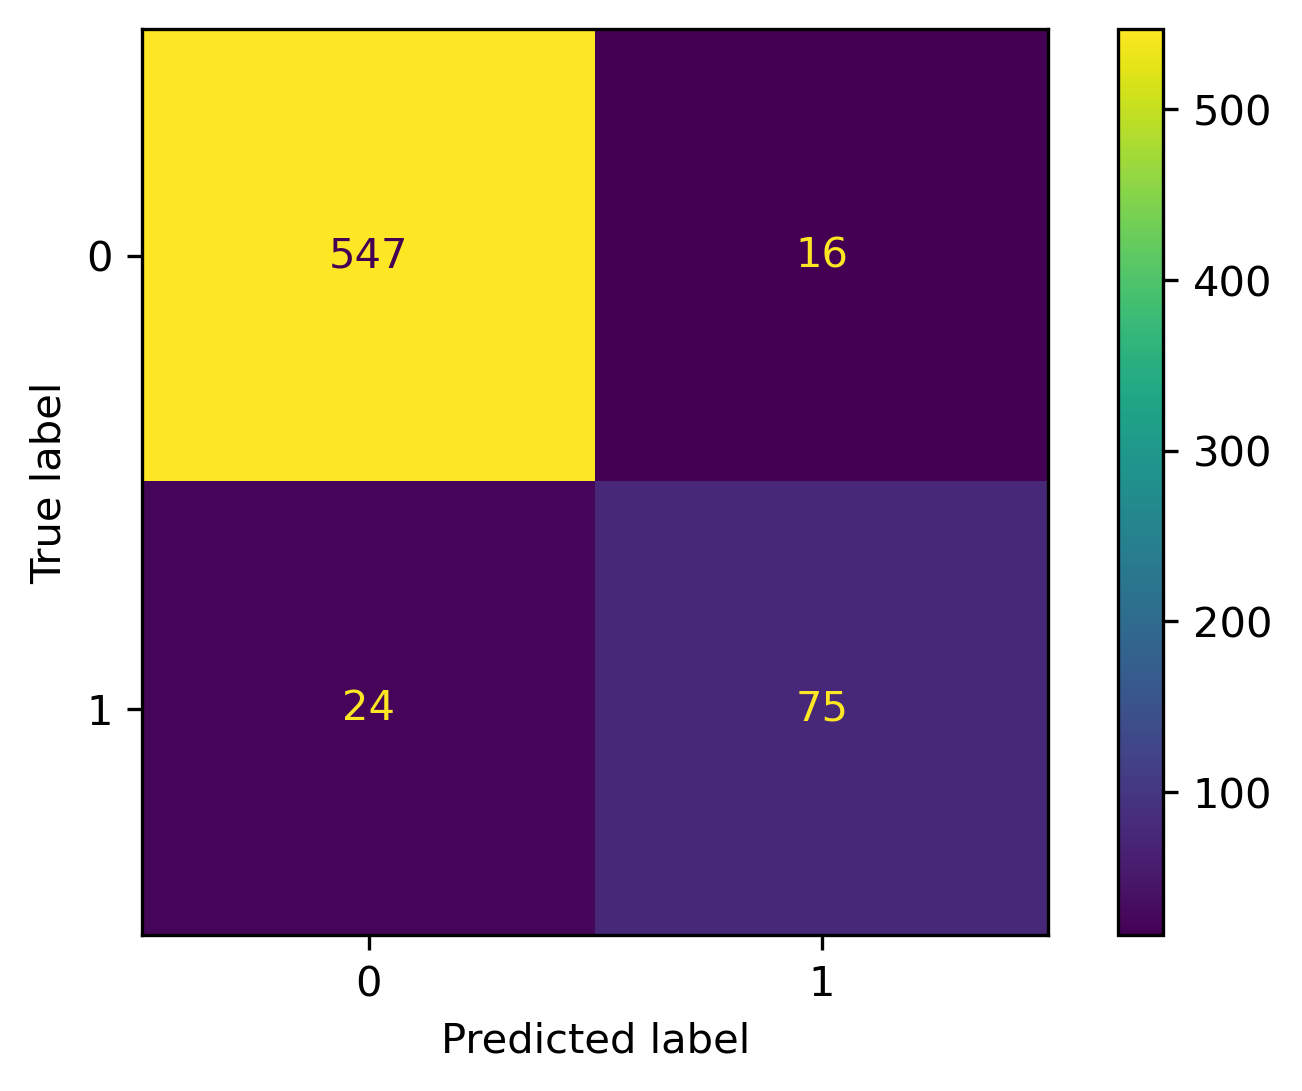

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [43]:
tn, fp, fn, tp = cm.ravel()

In [44]:
print('true neg: {0}%, false pos: {1}%, \
false neg: {2}%, true pos: {3}%'\
      .format(round((tn / len(test)) * 100, 2), round((fp / len(test)) * 100, 2), round((fn / len(test)) * 100, 2),\
              round((tp / len(test)) * 100, 2)))


true neg: 82.63%, false pos: 2.42%, false neg: 3.63%, true pos: 11.33%


In [45]:
# Classification_report() has two required fields: 
# the ground truth (y) and the binary predicted values (pred)

print(classification_report(test['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       563
           1       0.82      0.76      0.79        99

    accuracy                           0.94       662
   macro avg       0.89      0.86      0.88       662
weighted avg       0.94      0.94      0.94       662



In [46]:
loss_score = log_loss(test['Attrition'], prediction)

In [47]:
loss_score

2.086954455219503

In [48]:
auc=roc_auc_score(test['Attrition'],y_pred )
auc

0.9661445718284084

In [49]:
# plt.rcParams["font.family"] = "Arial"


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


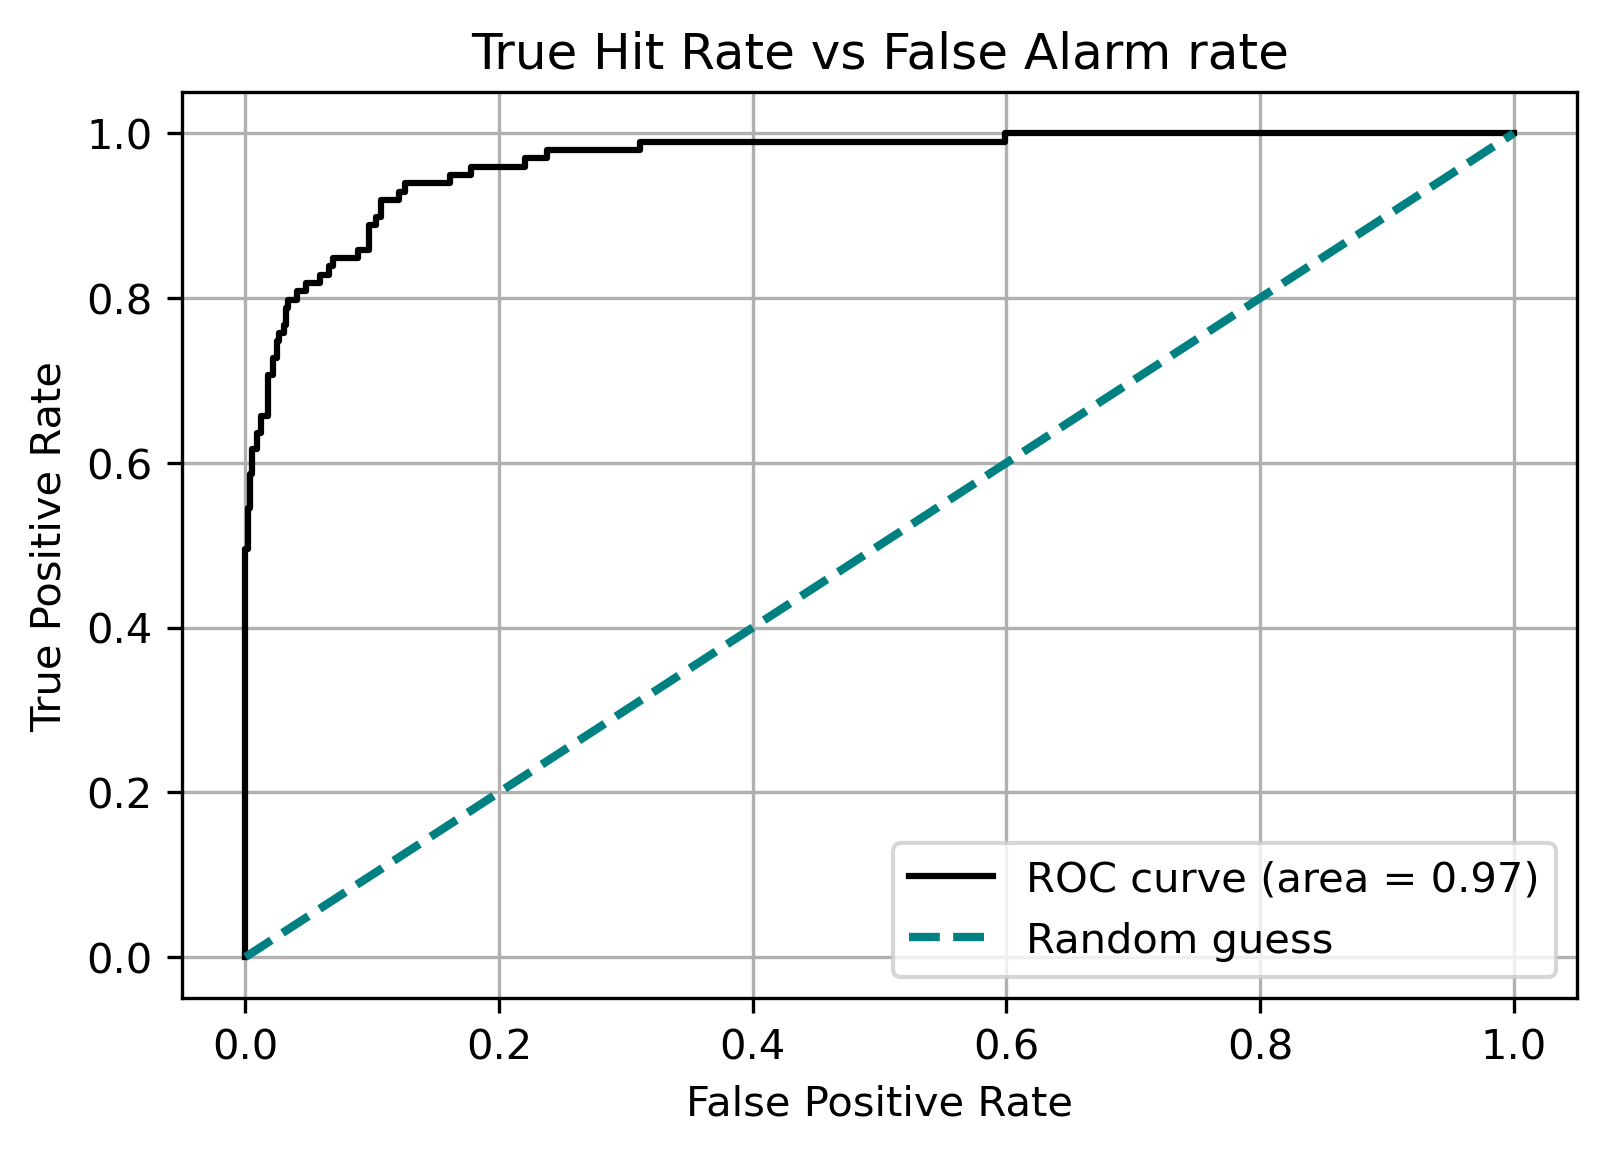

In [50]:
fpr, tpr, _ = roc_curve(test['Attrition'],  y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc, color='black')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='teal', label='Random guess')
plt.title('True Hit Rate vs False Alarm rate', family='Arial')
plt.ylabel('True Positive Rate', family='Arial')
plt.xlabel('False Positive Rate', family='Arial')
plt.grid()
plt.legend()
plt.show()